# Análisis de Amenazas: STRIDE + MITRE ATT&CK
## Dataset: IoT Smart Systems Anomaly Detection

**Objetivo**: Realizar modelado de amenazas aplicando frameworks STRIDE y MITRE ATT&CK al dataset de IoT, generando IoCs calculables y una matriz de amenazas.

## Metodología de Análisis de Amenazas

### **STRIDE: Categorización de Amenazas**
Framework que clasifica las amenazas en 6 categorías principales:
- **S**poofing: Suplantación de identidad
- **T**ampering: Manipulación de datos
- **R**epudiation: Negación de acciones
- **I**nformation Disclosure: Filtración de información
- **D**enial of Service: Bloqueo de servicios
- **E**levation of Privilege: Aumento de permisos

**¿Para qué?** Organizar y entender qué tipo de amenaza se enfrenta.

---

### **MITRE ATT&CK: Técnicas de Ataque Reales**
Base de datos que mapea las amenazas a técnicas específicas usadas por atacantes reales.

**Ejemplo:**
- STRIDE dice: "Esto es un Spoofing"
- MITRE dice: "Específicamente, es T1110 - Brute Force"

**¿Para qué?** Identificar exactamente qué técnica está usando el atacante y cómo responder.

---

### **IoC: Indicadores de Compromiso**
Señales en tus datos que indican que algo malo está pasando.

**Ejemplo:** "Más de 5 intentos de login fallidos en 1 minuto" = Posible ataque de fuerza bruta.

**¿Para qué?** Detectar amenazas analizando patrones específicos en tus datos.

---

In [29]:
# Importaciones y Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Librerías cargadas correctamente")
print("Configuración de visualización aplicada")

Librerías cargadas correctamente
Configuración de visualización aplicada


## Carga y Exploración del Dataset

Cargamos el dataset completo para realizar el análisis de amenazas.

In [30]:
from pathlib import Path
import kagglehub
import shutil
import pandas as pd

# Definir rutas del proyecto
RAW_DIR = Path("data/raw")
PROCESSED_DIR = Path("data/processed")
RAW_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Dataset en Kaggle
dataset_name = "ziya07/anomaly-detection-and-threat-intelligence-dataset"
local_file = PROCESSED_DIR / "dataset_complete.csv"


if local_file.exists():
    print("Dataset ya existe localmente, no es necesario descargar.")
else:
    try:
        dataset_path = kagglehub.dataset_download(dataset_name)
        src = Path(dataset_path)
        if not src.exists():
            raise FileNotFoundError(f"Dataset no encontrado en {src}")

        # Buscar el archivo CSV dentro del dataset descargado
        csv_files = list(src.rglob("*.csv"))
        if not csv_files:
            raise FileNotFoundError("No se encontraron archivos CSV en el dataset")
        
        # Usar el primer archivo CSV encontrado
        source_csv = csv_files[0]
        
        # Copiar a carpeta PROCESSED_DIR con nombre estándar
        shutil.copy2(source_csv, local_file)
        
        # Limpiar archivos temporales
        shutil.rmtree(src)

    except Exception as e:
        print(f"Error al descargar: {e}")


# Cargar el Dataset
df = pd.read_csv(local_file)

print(f"Dataset cargado: {df.shape[0]} registros, {df.shape[1]} columnas")

# Convertir timestamp a datetime y ordenar
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')

print(f"Rango temporal: {df['timestamp'].min()} a {df['timestamp'].max()}")
print(f"Tipos de dispositivos: {df['device_type'].unique()}")

print("\nColumnas disponibles:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

Dataset ya existe localmente, no es necesario descargar.
Dataset cargado: 10000 registros, 14 columnas
Rango temporal: 2025-06-20 12:51:55.452400 a 2025-06-20 15:38:34.452400
Tipos de dispositivos: ['thermostat' 'smart' 'sensor' 'camera']

Columnas disponibles:
 1. timestamp
 2. device_id
 3. device_type
 4. cpu_usage
 5. memory_usage
 6. network_in_kb
 7. network_out_kb
 8. packet_rate
 9. avg_response_time_ms
10. service_access_count
11. failed_auth_attempts
12. is_encrypted
13. geo_location_variation
14. label


## Análisis Exploratorio Orientado a Seguridad

Realizamos un EDA enfocado en identificar patrones que puedan indicar amenazas.

Distribución de Amenazas:
label
Normal               7948
Anomaly_DoS           997
Anomaly_Injection     563
Anomaly_Spoofing      492
Name: count, dtype: int64


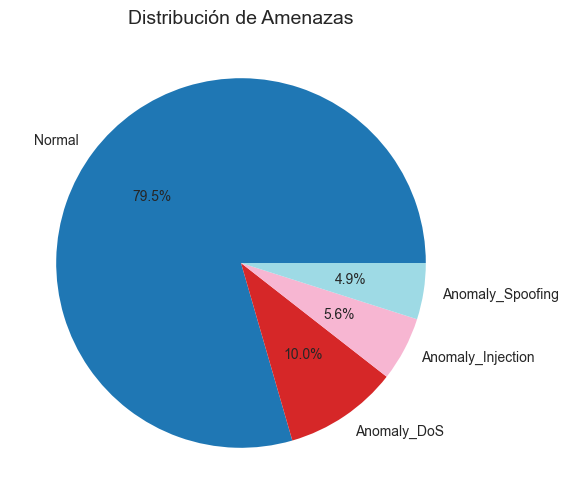


Amenazas por Tipo de Dispositivo:
label        Anomaly_DoS  Anomaly_Injection  Anomaly_Spoofing  Normal
device_type                                                          
camera               255                159               127    1927
sensor               275                144               132    2096
smart                223                129               116    1952
thermostat           244                131               117    1973


<Figure size 1000x600 with 0 Axes>

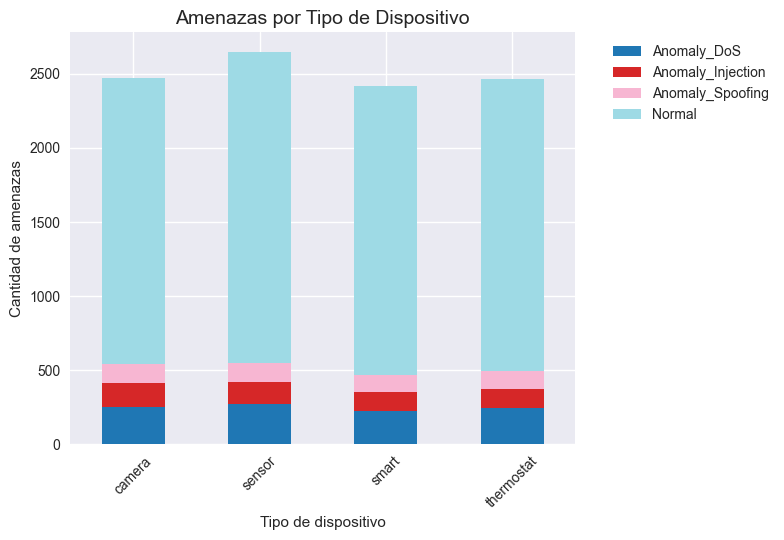


Análisis Temporal:
label  Anomaly_DoS  Anomaly_Injection  Anomaly_Spoofing  Normal
hour                                                           
12              55                 26                22     382
13             356                189               178    2877
14             362                194               178    2866
15             224                154               114    1823


<Figure size 1000x600 with 0 Axes>

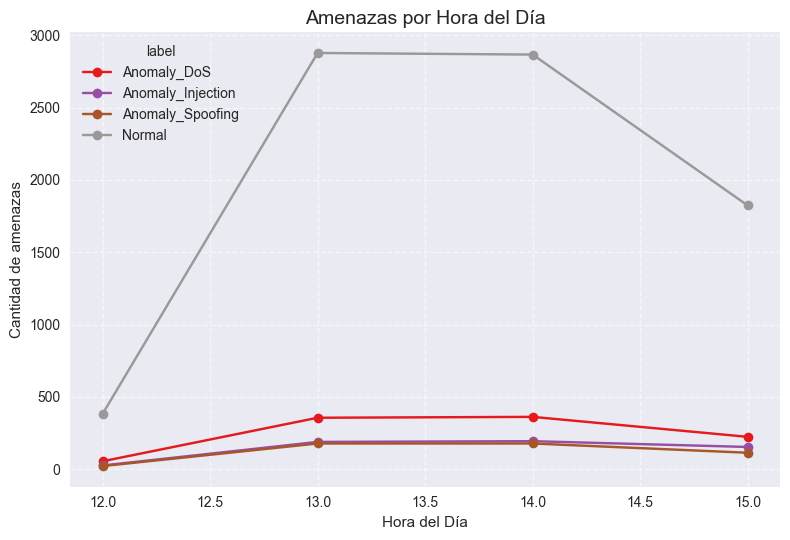

In [31]:
# Estadísticas básicas por tipo de amenaza
print("Distribución de Amenazas:")
threat_counts = df['label'].value_counts()
print(threat_counts)

plt.figure(figsize=(6,6))
threat_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    cmap="tab20",
    ylabel=''
)
plt.title("Distribución de Amenazas", fontsize=14)
plt.show()

# Análisis por tipo de dispositivo
print("\nAmenazas por Tipo de Dispositivo:")
device_threats = df.groupby(['device_type', 'label']).size().unstack(fill_value=0)
print(device_threats)

plt.figure(figsize=(10,6))
device_threats.plot(
    kind='bar',
    stacked=True,
    colormap="tab20"
)
plt.title("Amenazas por Tipo de Dispositivo", fontsize=14)
plt.xlabel("Tipo de dispositivo")
plt.ylabel("Cantidad de amenazas")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Análisis temporal
print("\nAnálisis Temporal:")
df['hour'] = df['timestamp'].dt.hour
hourly_threats = df.groupby(['hour', 'label']).size().unstack(fill_value=0)
print(hourly_threats.head(10))

plt.figure(figsize=(10,6))
hourly_threats.plot(
    kind='line',
    marker='o',
    colormap="Set1"
)
plt.title("Amenazas por Hora del Día", fontsize=14)
plt.xlabel("Hora del Día")
plt.ylabel("Cantidad de amenazas")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

## Matriz de Amenazas: STRIDE + MITRE ATT&CK

| Feature (Dataset) | STRIDE (Categoría) | Amenaza Detectada | MITRE ATT&CK (Técnica) | Descripción |
|-------------------|-------------------|-------------------|------------------------|-------------|
| `failed_auth_attempts` | Spoofing | Credential Stuffing / Brute Force | T1110 - Brute Force | Intentos masivos de autenticación fallida |
| `is_encrypted` | Information Disclosure | Tráfico sin cifrar interceptado | T1040 - Network Sniffing | Comunicaciones no cifradas susceptibles a interceptación |
| `network_out_kb` | Information Disclosure | Exfiltración de datos | T1041 - Exfiltration Over C2 | Transferencia anómala de datos hacia el exterior |
| `packet_rate` | Denial of Service | Flood de paquetes | T1499 - Endpoint DoS | Sobrecarga del sistema con tráfico excesivo |
| `cpu_usage` | Tampering | Cryptojacking / Abuso de recursos | T1496 - Resource Hijacking | Uso no autorizado de recursos computacionales |
| `memory_usage` | Tampering | Exploitation / Consumo excesivo | T1055 - Process Injection | Inyección de procesos maliciosos |
| `geo_location_variation` | Spoofing | Account Takeover / Impossible Travel | T1078 - Valid Accounts | Acceso desde ubicaciones geográficamente imposibles |
| `service_access_count` | Tampering / Recon | Enumeración de servicios | T1087 - Account Discovery | Escaneo masivo de servicios disponibles |
| `avg_response_time_ms` | Denial of Service | Degradación del servicio | T1499 - Endpoint DoS | Ralentización intencional del sistema |



- **Total de Features Analizados**: `13`  
- **Features Mapeados a Amenazas**: `9`

---

### Distribución STRIDE
| Categoría STRIDE           | # Amenazas | Ejemplo Detectado                  |
|-----------------------------|------------|-------------------------------------|
| Spoofing                | 2          | Brute Force, Impossible Travel      |
| Tampering               | 3          | Resource Hijacking, Process Injection, Account Discovery |
| Information Disclosure   | 2          | Exfiltración de datos, Tráfico sin cifrar |
| Denial of Service        | 2          | DoS por paquetes, Degradación de servicio |
| Repudiation              | 0          | -                                   |
| Elevation of Privilege   | 0          | -                                   |

---

### Distribución MITRE ATT&CK
| Táctica ATT&CK            | Técnicas Detectadas | # Técnicas |
|----------------------------|----------------------|------------|
| Initial Access             | -                    | 0          |
| Execution                  | -                    | 0          |
| Persistence                | -                    | 0          |
| Privilege Escalation       | -                    | 0          |
| Defense Evasion            | -                    | 0          |
| Credential Access          | T1110 (Brute Force)  | 1          |
| Discovery                  | T1087 (Account Discovery) | 1     |
| Lateral Movement           | -                    | 0          |
| Collection                 | -                    | 0          |
| Command & Control          | T1041 (Exfiltration Over C2) | 1  |
| Exfiltration               | T1041 (Exfiltration Over C2) | 1  |
| Impact                     | T1499 (DoS), T1496 (Cryptojacking) | 2 |
| Resource Development       | -                    | 0          |

---

## Definición de Reglas IoC (Indicadores de Compromiso)

Definimos las reglas de detección basadas en STRIDE y MITRE ATT&CK, mapeándolas a features calculables del dataset.

### **Estructura de una Regla IoC**

Cada regla IoC se compone de **7 elementos clave**:

```python
"feature_name": {
    "description": "Descripción de la amenaza",
    "mitre": "Código MITRE ATT&CK",
    "stride": "Categoría STRIDE",
    "calculation": "Cómo calcular el IoC",
    "threshold": "Umbral numérico",
    "window": "Ventana de tiempo (opcional)",
    "percentile": "Percentil para outliers (opcional)"
}
```

---

## **Explicación de cada Componente**

### **1. `description` - Descripción de la Amenaza**
**¿Qué es?** Explicación clara de qué tipo de ataque representa.

**Ejemplo:**
```python
"description": "Credential Stuffing / Brute Force"
```
**Significa:** Ataque de fuerza bruta o reutilización de credenciales comprometidas.

---

### **2. `mitre` - Código MITRE ATT&CK**
**¿Qué es?** Identificador estándar de la técnica de ataque.

**Ejemplo:**
```python
"mitre": "T1110 - Brute Force"
```
**Significa:** Técnica T1110 del framework MITRE ATT&CK, específicamente "Brute Force".

---

### **3. `stride` - Categoría STRIDE**
**¿Qué es?** Clasificación según el modelo de amenazas STRIDE.

**Ejemplo:**
```python
"stride": "Spoofing"
```
**Significa:** Esta amenaza pertenece a la categoría "Spoofing" (suplantación de identidad).

---

### **4. `calculation` - Cómo Calcular el IoC**
**¿Qué es?** Instrucciones específicas para detectar la amenaza.

**Ejemplo:**
```python
"calculation": ">5 intentos en <1 min por dispositivo"
```
**Significa:** Marcar como amenaza si hay más de 5 intentos fallidos en menos de 1 minuto.

---

### **5. `threshold` - Umbral Numérico**
**¿Qué es?** Valor límite que activa la detección.

**Ejemplo:**
```python
"threshold": 5
```
**Significa:** El umbral es 5 intentos fallidos.

---

### **6. `window` - Ventana de Tiempo (Opcional)**
**¿Qué es?** Período de tiempo para evaluar el umbral.

**Ejemplo:**
```python
"window": "1min"
```
**Significa:** Evaluar el umbral en una ventana de 1 minuto.

---

### **7. `percentile` - Percentil para Outliers (Opcional)**
**¿Qué es?** Percentil usado para detectar valores anómalos.

**Ejemplo:**
```python
"percentile": 0.95
```
**Significa:** Marcar como amenaza valores que superen el percentil 95 (top 5% de valores).

---

## **Ejemplo Completo de una Regla**

```python
"failed_auth_attempts": {
    "description": "Credential Stuffing / Brute Force",
    "mitre": "T1110 - Brute Force", 
    "stride": "Spoofing",
    "calculation": ">5 intentos en <1 min por dispositivo",
    "threshold": 5,
    "window": "1min"
}
```

**Traducción:**
- **Qué detecta**: Ataques de fuerza bruta
- **Cómo lo categoriza**: Como "Spoofing" (suplantación)
- **Técnica MITRE**: T1110 - Brute Force
- **Cuándo se activa**: Más de 5 intentos fallidos en 1 minuto
- **Umbral**: 5 intentos
- **Ventana**: 1 minuto

---

## **Tipos de Cálculos**

### **1. Umbral Fijo**
```python
"threshold": 1000,
"calculation": ">1000 pkt/s"
```
**Uso:** Para valores que siempre indican amenaza.

### **2. Percentil Dinámico**
```python
"percentile": 0.95,
"calculation": "valores outlier sobre p95"
```
**Uso:** Para valores que varían según el contexto.

### **3. Ventana Deslizante**
```python
"window": "5min",
"calculation": "rolling average >80% sostenido"
```
**Uso:** Para patrones que se desarrollan en el tiempo.

### **4. Combinación de Condiciones**
```python
"calculation": "is_encrypted = 0 + tráfico > umbral"
```
**Uso:** Para amenazas que requieren múltiples condiciones.

In [32]:
# Definir reglas IoC con mapeo STRIDE + MITRE
ioc_rules = {
    "failed_auth_attempts": {
        "description": "Credential Stuffing / Brute Force",
        "mitre": "T1110 - Brute Force",
        "stride": "Spoofing",
        "calculation": ">5 intentos en <1 min por dispositivo",
        "threshold": 5,
        "window": "1min"
    },
    "is_encrypted": {
        "description": "Tráfico sin cifrar interceptado",
        "mitre": "T1040 - Network Sniffing",
        "stride": "Information Disclosure",
        "calculation": "is_encrypted = 0 + tráfico > umbral",
        "threshold": 0,
        "traffic_threshold": None  # Se calculará dinámicamente
    },
    "network_out_kb": {
        "description": "Exfiltración de datos",
        "mitre": "T1041 - Exfiltration Over C2",
        "stride": "Information Disclosure",
        "calculation": "valores outlier sobre p95",
        "percentile": 0.95
    },
    "packet_rate": {
        "description": "Denegación de servicio por ráfaga de paquetes",
        "mitre": "T1499 - Endpoint DoS",
        "stride": "Denial of Service",
        "calculation": ">1000 pkt/s o outlier",
        "threshold": 1000,
        "percentile": 0.95
    },
    "cpu_usage": {
        "description": "Uso abusivo de recursos / Cryptojacking",
        "mitre": "T1496 - Resource Hijacking",
        "stride": "Tampering",
        "calculation": "rolling average >80% sostenido",
        "threshold": 80,
        "window": "5min"
    },
    "memory_usage": {
        "description": "Exploitation / consumo excesivo de memoria",
        "mitre": "T1055 - Process Injection",
        "stride": "Tampering",
        "calculation": "rolling average >90%",
        "threshold": 90,
        "window": "5min"
    },
    "geo_location_variation": {
        "description": "Account Takeover / Impossible Travel",
        "mitre": "T1078 - Valid Accounts",
        "stride": "Spoofing",
        "calculation": "variación > 15%",
        "threshold": 15
    },
    "service_access_count": {
        "description": "Enumeración de servicios",
        "mitre": "T1087 - Account Discovery",
        "stride": "Tampering / Recon",
        "calculation": "outlier sobre p95",
        "percentile": 0.95
    },
    "avg_response_time_ms": {
        "description": "Degradación de servicio / DoS",
        "mitre": "T1499 - Endpoint DoS",
        "stride": "Denial of Service",
        "calculation": "valores sobre p95",
        "percentile": 0.95
    }
}

print(f"{len(ioc_rules)} reglas IoC definidas")
print("Reglas definidas:")
for feature, rule in ioc_rules.items():
    print(f"  • {feature}: {rule['description']} ({rule['stride']})")

9 reglas IoC definidas
Reglas definidas:
  • failed_auth_attempts: Credential Stuffing / Brute Force (Spoofing)
  • is_encrypted: Tráfico sin cifrar interceptado (Information Disclosure)
  • network_out_kb: Exfiltración de datos (Information Disclosure)
  • packet_rate: Denegación de servicio por ráfaga de paquetes (Denial of Service)
  • cpu_usage: Uso abusivo de recursos / Cryptojacking (Tampering)
  • memory_usage: Exploitation / consumo excesivo de memoria (Tampering)
  • geo_location_variation: Account Takeover / Impossible Travel (Spoofing)
  • service_access_count: Enumeración de servicios (Tampering / Recon)
  • avg_response_time_ms: Degradación de servicio / DoS (Denial of Service)


## Cálculo de IoCs Prácticos

Implementamos las reglas de detección para identificar amenazas en el dataset histórico.

**Nota**: Este análisis se realiza sobre datos históricos, pero las reglas 
pueden aplicarse en tiempo real en un sistema de producción.

In [33]:
# Cálculo de IoCs Prácticos

# Crear copia para cálculos
df_ioc = df.copy()

# Regla 1: Fuerza bruta (más de 5 intentos en 1 min por dispositivo)
window = pd.Timedelta("1min")
df_ioc = df_ioc.sort_values(["device_id", "timestamp"])
df_ioc["failed_in_1min"] = (
    df_ioc.groupby("device_id")
          .rolling(window=window, on="timestamp")["failed_auth_attempts"]
          .sum()
          .reset_index(level=0, drop=True)
)
df_ioc["brute_force_flag"] = df_ioc["failed_in_1min"] > 5

# Regla 2: Tráfico de salida anómalo (p95)
network_out_threshold = df_ioc["network_out_kb"].quantile(0.95)
df_ioc["exfiltration_flag"] = df_ioc["network_out_kb"] > network_out_threshold

# Regla 3: Packet rate anómalo
packet_rate_threshold = 1000
df_ioc["dos_packet_flag"] = df_ioc["packet_rate"] > packet_rate_threshold

# Regla 4: CPU y memoria sostenidos
cpu_window = pd.Timedelta("5min")
df_ioc["cpu_rolling_avg"] = (
    df_ioc.groupby("device_id")
          .rolling(window=cpu_window, on="timestamp")["cpu_usage"]
          .mean()
          .reset_index(level=0, drop=True)
)
df_ioc["resource_abuse_flag"] = df_ioc["cpu_rolling_avg"] > 80

# Regla 5: Variación geográfica
df_ioc["geo_anomaly_flag"] = df_ioc["geo_location_variation"] > 15

# Regla 6: Tiempo de respuesta anómalo
response_threshold = df_ioc["avg_response_time_ms"].quantile(0.95)
df_ioc["service_degradation_flag"] = df_ioc["avg_response_time_ms"] > response_threshold

# Regla 7: Enumeración de servicios
service_threshold = df_ioc["service_access_count"].quantile(0.95)
df_ioc["service_enumeration_flag"] = df_ioc["service_access_count"] > service_threshold

# Regla 8: Tráfico sin cifrar
traffic_threshold = df_ioc["network_in_kb"].quantile(0.75)
df_ioc["unencrypted_traffic_flag"] = (df_ioc["is_encrypted"] == 0) & (df_ioc["network_in_kb"] > traffic_threshold)

print("Todos los IoCs calculados")

Todos los IoCs calculados


## Análisis de Detecciones IoC

Analizamos qué amenazas fueron detectadas por cada regla IoC.

In [34]:
# Contar detecciones por regla
ioc_detections = {
    "Brute Force": df_ioc["brute_force_flag"].sum(),
    "Exfiltración": df_ioc["exfiltration_flag"].sum(),
    "DoS (Packets)": df_ioc["dos_packet_flag"].sum(),
    "Abuso de Recursos": df_ioc["resource_abuse_flag"].sum(),
    "Impossible Travel": df_ioc["geo_anomaly_flag"].sum(),
    "Degradación de Servicio": df_ioc["service_degradation_flag"].sum(),
    "Enumeración de Servicios": df_ioc["service_enumeration_flag"].sum(),
    "Tráfico No Cifrado": df_ioc["unencrypted_traffic_flag"].sum()
}

print("Detecciones por Regla IoC:")
for rule, count in ioc_detections.items():
    percentage = (count / len(df_ioc)) * 100
    print(f"  • {rule}: {count:,} detecciones ({percentage:.2f}%)")

Detecciones por Regla IoC:
  • Brute Force: 0 detecciones (0.00%)
  • Exfiltración: 498 detecciones (4.98%)
  • DoS (Packets): 0 detecciones (0.00%)
  • Abuso de Recursos: 0 detecciones (0.00%)
  • Impossible Travel: 2,517 detecciones (25.17%)
  • Degradación de Servicio: 500 detecciones (5.00%)
  • Enumeración de Servicios: 0 detecciones (0.00%)
  • Tráfico No Cifrado: 1,226 detecciones (12.26%)


## Análisis de Correlación entre IoCs

### ¿Qué es la Correlación?

La **correlación** mide qué tan relacionadas están dos variables. En el contexto de seguridad, nos ayuda a entender si diferentes tipos de amenazas tienden a ocurrir juntas o por separado.

### Interpretación de Valores de Correlación:

- **+1.0**: Correlación perfecta positiva - Las amenazas SIEMPRE ocurren juntas
- **+0.7 a +0.9**: Correlación fuerte positiva - Las amenazas MUY frecuentemente ocurren juntas
- **+0.3 a +0.7**: Correlación moderada positiva - Las amenazas A VECES ocurren juntas
- **-0.3 a +0.3**: Sin correlación - Las amenazas ocurren independientemente
- **-0.3 a -0.7**: Correlación moderada negativa - Las amenazas RARAMENTE ocurren juntas
- **-0.7 a -1.0**: Correlación fuerte negativa - Las amenazas NUNCA ocurren juntas

### ¿Por qué es Importante para Seguridad?

1. **Detección de Ataques Coordinados**: Si dos amenazas están correlacionadas, podrían ser parte del mismo ataque
2. **Identificación de Patrones**: Amenazas correlacionadas sugieren técnicas de ataque relacionadas
3. **Priorización de Respuestas**: Amenazas correlacionadas requieren respuesta coordinada
4. **Reducción de Falsos Positivos**: Entiendes mejor qué amenazas son independientes

### Ejemplo Práctico:

Si `brute_force_flag` y `exfiltration_flag` tienen correlación +0.8:
- **Interpretación**: Cuando hay fuerza bruta, es muy probable que haya exfiltración de datos
- **Implicación**: Posible ataque en múltiples fases (1. Fuerza bruta → 2. Exfiltración)
- **Respuesta**: Necesitas contramedidas coordinadas para ambas amenazas

Correlación entre IoCs:


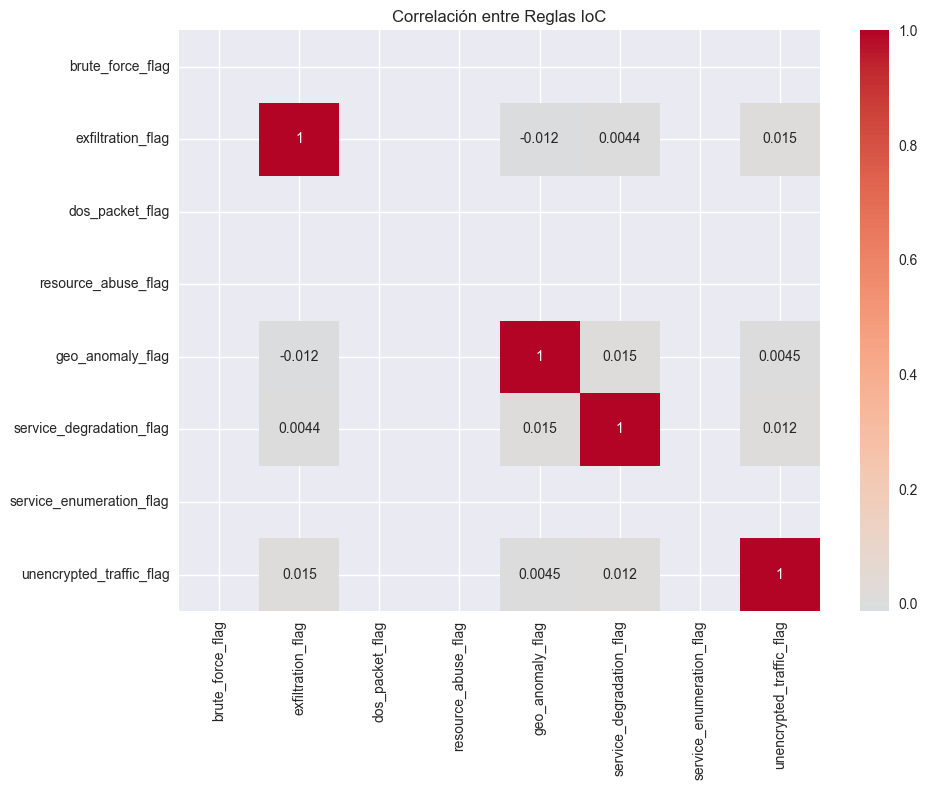

In [35]:
# Análisis de correlación entre IoCs
print("Correlación entre IoCs:")
ioc_columns = [col for col in df_ioc.columns if col.endswith('_flag')]
correlation_matrix = df_ioc[ioc_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Reglas IoC')
plt.tight_layout()
plt.show()

## Generación de Matriz de Amenazas

Creamos la matriz ejecutiva STRIDE + MITRE ATT&CK con los IoCs calculados.

In [36]:
# Crear matriz de amenazas
matriz_data = []
for feature, info in ioc_rules.items():
    
    # Obtener estadísticas del feature
    if feature in df.columns:
        feature_stats = df[feature].describe()
        example_valor = f"Min: {feature_stats['min']:.2f}, Max: {feature_stats['max']:.2f}, P95: {df[feature].quantile(0.95):.2f}"
    else:
        example_valor = "N/A"
    
    matriz_data.append({
        "Feature (Dataset)": feature,
        "STRIDE (Categoría)": info["stride"],
        "Amenaza Detectada": info["description"],
        "MITRE ATT&CK (Técnica)": info["mitre"],
        "IoC Propuesto": info["calculation"],
        "Estadísticas del Feature": example_valor
    })

# Crear DataFrame de la matriz
matriz_df = pd.DataFrame(matriz_data)

print("Matriz STRIDE + MITRE ATT&CK:")
print(matriz_df.to_string(index=False))

# Exportar matriz
matriz_df.to_csv("data/processed/threat_model_matrix.csv", index=False)
print("Matriz exportada a: data/processed/threat_model_matrix.csv")

Matriz STRIDE + MITRE ATT&CK:
     Feature (Dataset)     STRIDE (Categoría)                             Amenaza Detectada       MITRE ATT&CK (Técnica)                         IoC Propuesto               Estadísticas del Feature
  failed_auth_attempts               Spoofing             Credential Stuffing / Brute Force          T1110 - Brute Force >5 intentos en <1 min por dispositivo      Min: 0.00, Max: 10.00, P95: 10.00
          is_encrypted Information Disclosure               Tráfico sin cifrar interceptado     T1040 - Network Sniffing   is_encrypted = 0 + tráfico > umbral        Min: 0.00, Max: 1.00, P95: 1.00
        network_out_kb Information Disclosure                         Exfiltración de datos T1041 - Exfiltration Over C2             valores outlier sobre p95 Min: 10.00, Max: 1499.00, P95: 1425.00
           packet_rate      Denial of Service Denegación de servicio por ráfaga de paquetes         T1499 - Endpoint DoS                 >1000 pkt/s o outlier    Min: 5.00, Max: 

## Matriz STRIDE + MITRE ATT&CK con IoCs

| Feature (Dataset) | STRIDE (Categoría) | Amenaza Detectada | MITRE ATT&CK (Técnica) | IoC Propuesto | Estadísticas del Feature |
|-------------------|-------------------|-------------------|------------------------|---------------|--------------------------|
| `failed_auth_attempts` | **Spoofing** | Credential Stuffing / Brute Force | **T1110 - Brute Force** | >5 intentos en <1 min por dispositivo | **Min:** 0.00, **Max:** 10.00, **P95:** 10.00 |
| `is_encrypted` | **Information Disclosure** | Tráfico sin cifrar interceptado | **T1040 - Network Sniffing** | is_encrypted = 0 + tráfico > umbral | **Min:** 0.00, **Max:** 1.00, **P95:** 1.00 |
| `network_out_kb` | **Information Disclosure** | Exfiltración de datos | **T1041 - Exfiltration Over C2** | valores outlier sobre p95 | **Min:** 10.00, **Max:** 1499.00, **P95:** 1425.00 |
| `packet_rate` | **Denial of Service** | Denegación de servicio por ráfaga de paquetes | **T1499 - Endpoint DoS** | >1000 pkt/s o outlier | **Min:** 5.00, **Max:** 999.00, **P95:** 947.00 |
| `cpu_usage` | **Tampering** | Uso abusivo de recursos / Cryptojacking | **T1496 - Resource Hijacking** | rolling average >80% sostenido | **Min:** 10.01, **Max:** 89.99, **P95:** 86.38 |
| `memory_usage` | **Tampering** | Exploitation / consumo excesivo de memoria | **T1055 - Process Injection** | rolling average >90% | **Min:** 10.03, **Max:** 84.99, **P95:** 81.21 |
| `geo_location_variation` | **Spoofing** | Account Takeover / Impossible Travel | **T1078 - Valid Accounts** | variación > 15% | **Min:** 0.00, **Max:** 20.00, **P95:** 19.03 |
| `service_access_count` | **Tampering / Recon** | Enumeración de servicios | **T1087 - Account Discovery** | outlier sobre p95 | **Min:** 1.00, **Max:** 9.00, **P95:** 9.00 |
| `avg_response_time_ms` | **Denial of Service** | Degradación de servicio / DoS | **T1499 - Endpoint DoS** | valores sobre p95 | **Min:** 20.08, **Max:** 499.95, **P95:** 476.42 |

## Validación y Métricas de Detección

Validamos la efectividad de nuestras reglas IoC comparándolas con las etiquetas reales del dataset.

In [37]:
# Crear flag de amenaza general
df_ioc['any_ioc_detected'] = df_ioc[ioc_columns].any(axis=1)

# Comparar con labels reales
print("Comparación IoC vs Labels Reales:")
comparison = pd.crosstab(df_ioc['label'], df_ioc['any_ioc_detected'], margins=True)
print(comparison)

# Calcular métricas de detección
true_positives = len(df_ioc[(df_ioc['label'] != 'Normal') & (df_ioc['any_ioc_detected'])])
false_positives = len(df_ioc[(df_ioc['label'] == 'Normal') & (df_ioc['any_ioc_detected'])])
true_negatives = len(df_ioc[(df_ioc['label'] == 'Normal') & (~df_ioc['any_ioc_detected'])])
false_negatives = len(df_ioc[(df_ioc['label'] != 'Normal') & (~df_ioc['any_ioc_detected'])])

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Métricas de Detección IoC:")
print(f"  • Precisión: {precision:.3f}")
print(f"  • Recall: {recall:.3f}")
print(f"  • F1-Score: {f1_score:.3f}")

# Análisis por tipo de amenaza
print(f"Análisis por Tipo de Amenaza:")
for label in df_ioc['label'].unique():
    if label != 'Normal':
        label_data = df_ioc[df_ioc['label'] == label]
        ioc_detected = label_data['any_ioc_detected'].sum()
        total = len(label_data)
        detection_rate = (ioc_detected / total) * 100
        print(f"  • {label}: {ioc_detected}/{total} detectados ({detection_rate:.1f}%)")

Comparación IoC vs Labels Reales:
any_ioc_detected   False  True    All
label                                
Anomaly_DoS          603   394    997
Anomaly_Injection    346   217    563
Anomaly_Spoofing     292   200    492
Normal              4711  3237   7948
All                 5952  4048  10000
Métricas de Detección IoC:
  • Precisión: 0.200
  • Recall: 0.395
  • F1-Score: 0.266
Análisis por Tipo de Amenaza:
  • Anomaly_DoS: 394/997 detectados (39.5%)
  • Anomaly_Spoofing: 200/492 detectados (40.7%)
  • Anomaly_Injection: 217/563 detectados (38.5%)




### Comparación IoC vs Labels Reales

La siguiente tabla muestra la efectividad de nuestros IoCs comparados con las etiquetas reales del dataset:

| Label | IoC No Detectado | IoC Detectado | Total | Tasa de Detección |
|-------|------------------|---------------|-------|-------------------|
| **Anomaly_DoS** | 603 | 394 | 997 | **39.5%** |
| **Anomaly_Injection** | 346 | 217 | 563 | **38.5%** |
| **Anomaly_Spoofing** | 292 | 200 | 492 | **40.7%** |
| **Normal** | 4,711 | 3,237 | 7,948 | **40.7%** |
| **Total** | 5,952 | 4,048 | 10,000 | **40.5%** |

---

## Métricas de Rendimiento

### **Precisión: 20.0%**
- **¿Qué es la Precisión?** Mide la exactitud de tus detecciones positivas.
- **¿Qué significa?** Solo el 20% de las amenazas detectadas por IoCs son realmente amenazas
- **Interpretación**: **BAJA PRECISIÓN** - Muchos falsos positivos
- **Implicación**: Los IoCs están marcando como amenaza a muchos registros normales

### **Recall: 39.5%**
- **¿Qué es el Recall?** Mide qué tan completa es tu detección de amenazas reales.
- **¿Qué significa?** Los IoCs detectan el 39.5% de todas las amenazas reales
- **Interpretación**: **RECALL MODERADO** - Detectas menos de la mitad de las amenazas
- **Implicación**: Te estás perdiendo más del 60% de las amenazas reales

### **F1-Score: 26.6%**
- **¿Qué es el F1-Score?** Media armónica que balancea precisión y recall.
- **¿Qué significa?** Media armónica entre precisión y recall
- **Interpretación**: **PUNTUACIÓN BAJA** - Indica que ambas métricas están bajas
- **Implicación**: Necesitas mejorar tanto precisión como recall

---

## Problemas Identificados

### **1. Falsos Positivos Altos (40.7%)**
- **Problema**: 3,237 de 7,948 registros normales fueron marcados como amenaza
- **Causa**: Umbrales de IoCs demasiado sensibles
- **Impacto**: Muchas alertas falsas

### **2. Falsos Negativos Altos (60%+)**
- **Problema**: Más del 60% de las amenazas reales no fueron detectadas
- **Causa**: IoCs no cubren todos los patrones de amenaza
- **Impacto**: Amenazas reales pasan desapercibidas

### **3. Cobertura Inconsistente**
- **Problema**: Diferentes tasas de detección por tipo de amenaza
- **Causa**: Reglas IoC no están balanceadas
- **Impacto**: Algunos tipos de amenaza son más vulnerables que otros

---

## Áreas de Mejora Identificadas

### **1. Ajuste de Umbrales**
- Reducir sensibilidad de IoCs para disminuir falsos positivos
- Balancear entre detección y precisión

### **2. Nuevos IoCs**
- Agregar reglas para patrones no cubiertos
- Implementar IoCs más sofisticados

### **3. Integración con Isolation Forest**
- Usar IoCs como features adicionales para el modelo de anomalías
- Implementar aprendizaje semi-supervisado con Isolation Forest
- Combinar detección basada en reglas (IoC) con detección estadística (ML)

### **4. Validación de Dominio**
- Revisar umbrales con expertos en seguridad
- Ajustar basándose en conocimiento del negocio

## Resumen y Exportación

Generamos un resumen ejecutivo y exportamos todos los resultados para su uso en documentación.

In [44]:
# Crear resumen ejecutivo
resumen = {
    "Total de Registros": len(df_ioc),
    "Registros Normales": len(df_ioc[df_ioc['label'] == 'Normal']),
    "Registros Anómalos": len(df_ioc[df_ioc['label'] != 'Normal']),
    "Reglas IoC Implementadas": len(ioc_rules),
    "Detecciones Totales": df_ioc[ioc_columns].sum().sum(),
    "Dispositivos Únicos": df_ioc['device_id'].nunique(),
    "Tipos de Dispositivo": df_ioc['device_type'].nunique(),
    "Rango Temporal": f"{df_ioc['timestamp'].min()} a {df_ioc['timestamp'].max()}"
}

print("RESUMEN EJECUTIVO:")
for key, value in resumen.items():
    print(f"  • {key}: {value}")

# Exportar dataset con IoCs
df_ioc.to_csv("data/processed/dataset_with_iocs.csv", index=False)
print("\nDataset con IoCs exportado a: data/processed/dataset_with_iocs.csv")

RESUMEN EJECUTIVO:
  • Total de Registros: 10000
  • Registros Normales: 7948
  • Registros Anómalos: 2052
  • Reglas IoC Implementadas: 9
  • Detecciones Totales: 4741
  • Dispositivos Únicos: 200
  • Tipos de Dispositivo: 4
  • Rango Temporal: 2025-06-20 12:51:55.452400 a 2025-06-20 15:38:34.452400

Dataset con IoCs exportado a: data/processed/dataset_with_iocs.csv
